# A comprehensive study of DPNets on the logistic map

In [133]:
%load_ext autoreload
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml', register_jax_pytree=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
%autoreload 2
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.linalg
from scipy.integrate import romb
from rich.console import Console
from rich.table import Table
#Set plotting styles
import scienceplots
plt.style.use(['nature', 'retro'])
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

#Torch imports
import lightning
import torch
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import LearningRateFinder

#Kooplearn imports
from kooplearn.abc import FeatureMap
from kooplearn.models.feature_maps import ConcatenateFeatureMaps
from kooplearn.datasets import LogisticMap
from kooplearn._src.metrics import directed_hausdorff_distance
from kooplearn.nn.data import TrajToContextsDataset

# Noisy Logistic map
We initialize the `kooplearn.dataset` corresponding to the noisy logistic map and plot the true singular values and eigenvalues, showing the non-normality of the dynamical system

In [135]:
logistic = LogisticMap(N = configs.N)

In [136]:
num_train = 50000
num_val = 10000
num_test = 10000
sample_traj = logistic.sample(0.5, num_train+num_val+num_test)
dataset = {
    'train': sample_traj[:num_train],
    'validation': sample_traj[num_train:num_train+num_val],
    'test': sample_traj[num_train+num_val:]
}

The logistic map is a non-normal dynamical system. This can be visualized by comparing the eigenvalues against the singular values of the transfer operator:

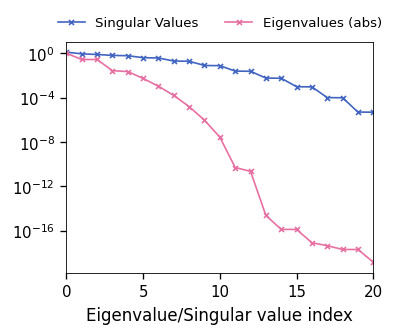

In [137]:
plt.plot(logistic.svals(), 'x-', label= 'Singular Values')
plt.plot(np.abs(logistic.eig()), 'x-', label = 'Eigenvalues (abs)')
plt.margins(x=0)
plt.yscale('log')
plt.xlabel("Eigenvalue/Singular value index")
plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1., 1, 0), ncol=2, fontsize=8)

# Setting up an evaluation scheme.

## Population estimators
As we are able to compute everything for this system, we evaluate the performance of `DPNets` in two stages. In the first stage we take three different feature maps:
1. Chebyshev polynomials up to order $\ell$
2. `VAMPNets` with latent dimension $\ell$ (MLP architecture tbd)
3. `DPNets` with latend dimension $\ell$ (MLP architecture tbd)

Given $\phi \colon [0, 1]\to \mathbb{R}^{\ell}$, we evaluate $C_{ij} := \int_{0}^{1} \phi_{i}(x)\phi_{j}(x) \pi(dx)$, where $\pi$ is the invariant distribution. And the cross covariance $C_{ij}^{\times} := \int_{0}^{1} \phi_{i}(x)\phi_{j}(y) \pi(dx)p(x, dy) = \sum_{n = 0}^{N}\left(\int_{0}^{1} \phi_{i}(x)\alpha_{n}(x)\pi(dx)\right)\left(\int_{0}^{1} \phi_{j}(y)\beta_{n}(y)dy\right)$. As the kernel is separable, I just need to compute $2(N + 1)$ single integrals. 

Now, the OLS Transfer operator estimator is $G_{{\rm OLS}} = C^{\dagger}C^{\times}$, from which I can compute:
1. Directed Hausdorff spectral distance
2. Approximation error $\Vert [I - P_{\mathcal{H}}]\mathcal{T}|_{\mathcal{H}}\Vert$, for which $\mathcal{P}$ and $\mathcal{S}$ are proxies.
3. VAMP-score $\mathcal{P}$ + something related to metric distortion. An example could be $\mathcal{P}/\kappa (C)$

## Empirical estimators
In the second stage we pull into the ring every Koopman estimator we have and we compute, from data:

- Directed Hausdorff distance as a metric for the spectral estimation.
- MAE on 1-step ahead conditional expectation. Even if the system is stochastic, since it is of the form $X_{t + 1} = F(X_t) + \xi_{t}$ where $\xi_{t}$ is zero-mean, the expected value conditioned on $X_t = x$ is just $F(x)$.

# Population validators

In [138]:
def population_covs(feature_map: FeatureMap, pow_of_two_k: int = 12):
    """Computes the population covariance and cross-covariance"""
    x = np.linspace(0, 1, 2**pow_of_two_k + 1)[:, None]
    vals, lv = logistic.eig(eval_left_on=x)
    perron_eig_idx = np.argmax(np.abs(vals))
    pi = lv[:, perron_eig_idx]
    assert np.isreal(pi).all()
    pi = pi.real
    pi = pi/romb(pi, dx = 1/2**pow_of_two_k) #Normalization of \pi
    #Evaluating the feature map
    phi = feature_map(x) # [2**pow_of_two_k + 1, d]
    #Covariance
    cov_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*phi.reshape(2**pow_of_two_k + 1, 1, -1)*pi.reshape(-1, 1, 1)
    cov = romb(cov_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    #Cross-covariance
    alphas = np.stack([logistic.noise_feature_composed_map(x, n) for n in range(logistic.N + 1)], axis = 1)
    betas = np.stack([logistic.noise_feature(x, n) for n in range(logistic.N + 1)], axis = 1)

    cov_alpha_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*alphas.reshape(2**pow_of_two_k + 1, 1, -1)*pi.reshape(-1, 1, 1)
    cov_beta_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*betas.reshape(2**pow_of_two_k + 1, 1, -1)

    cov_alpha = romb(cov_alpha_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    cov_beta = romb(cov_beta_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    
    cross_cov = cov_alpha@(cov_beta.T)
    return cov, cross_cov

def evaluate_representation(feature_map: FeatureMap):
    report = {}
    #Compute OLS estimator
    cov, cross_cov = population_covs(feature_map)
    OLS_estimator = np.linalg.solve(cov, cross_cov)
    #Eigenvalue estimation
    OLS_eigs = np.linalg.eigvals(OLS_estimator)
    report['hausdorff-dist'] = directed_hausdorff_distance(OLS_eigs, logistic.eig())
    #VAMP2-score
    M = np.linalg.multi_dot([np.linalg.pinv(cov, hermitian=True), cross_cov, np.linalg.pinv(cov, hermitian=True), cross_cov.T])
    report['SVD-error'] = np.sum(logistic.svals()**2) - np.trace(M)
    #Metric distortion
    cov_eigs = np.linalg.eigvalsh(cov)
    report['fro-Id-cov'] = np.mean((cov_eigs - np.ones_like(cov_eigs))**2)
    report['feature-map'] = feature_map
    return report

def tabulate_reports(reports):
    console = Console()
    table = Table(show_header=True, header_style="bold")
    table.add_column("Representation", justify='right')
    table.add_column("Hausdorff dist",justify='center')
    table.add_column("SVD Error",justify='center')
    table.add_column("||Id - cov||^2",justify='center')
    for model_name, model_report in reports.items():
        hausdorff = f"{model_report['hausdorff-dist']:.3f}"
        SVD_err = f"{model_report['SVD-error']:.3f}"
        fro_dist = f"{model_report['fro-Id-cov']:.3f}"
        table.add_row(model_name, hausdorff, SVD_err, fro_dist)
    console.print(table)

def flatten_reports(reports):
    #Reports must all be of depth 1 and with the same shape. No checks are performed 
    flattened = {}
    for model_name, model_report in reports.items():
        for report_stub, value in model_report.items():
            if report_stub in flattened:
                flattened[report_stub].append(value)
            else:
                flattened[report_stub] = [value]
    return flattened

# Chebyshev polynomials of the first kind

In [139]:
def ChebyT(order: int = 3):
    def scaled_chebyt(n, x):
        return scipy.special.eval_chebyt(n, 2*x - 1)
    fn_list = [partial(scaled_chebyt, n) for n in range(order + 1)]
    return ConcatenateFeatureMaps(fn_list)   

In [140]:
reports = {}
for i in range(1, 41):
    model_name = f"ChebyT-{i}"
    reports[model_name] = evaluate_representation(ChebyT(i))
flattened = flatten_reports(reports)
tabulate_reports(reports)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Representation ┃ Hausdorff dist ┃ SVD Error ┃ ||Id - cov||^2 ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│       ChebyT-1 │     0.007      │   3.037   │     0.172      │
│       ChebyT-2 │     0.235      │   2.669   │     0.239      │
│       ChebyT-3 │     0.253      │   2.555   │     0.263      │
│       ChebyT-4 │     0.196      │   1.775   │     0.277      │
│       ChebyT-5 │     0.201      │   1.763   │     0.282      │
│       ChebyT-6 │     0.202      │   1.327   │     0.284      │
│       ChebyT-7 │     0.204      │   1.325   │     0.285      │
│       ChebyT-8 │     0.095      │   0.948   │     0.285      │
│       ChebyT-9 │     0.097      │   0.945   │     0.285      │
│      ChebyT-10 │     0.090      │   0.640   │     0.285      │
│      ChebyT-11 │     0.093      │   0.638   │     0.285      │
│      ChebyT-12 │     0.061      │   0.441   │     0.284      │
│      ChebyT-13 │     0.062      │   0.441   │     0.284      │
│      ChebyT-14 │     0.058      │   0.295   │     0.284      │
│      ChebyT-15 │     0.060      │   0.295   │     0.284      │
│      ChebyT-16 │     0.036      │   0.193   │     0.283      │
│      ChebyT-17 │     0.037      │   0.193   │     0.283      │
│      ChebyT-18 │     0.033      │   0.128   │     0.283      │
│      ChebyT-19 │     0.034      │   0.128   │     0.283      │
│      ChebyT-20 │     0.018      │   0.087   │     0.283      │
│      ChebyT-21 │     0.018      │   0.087   │     0.283      │
│      ChebyT-22 │     0.016      │   0.061   │     0.282      │
│      ChebyT-23 │     0.017      │   0.061   │     0.282      │
│      ChebyT-24 │     0.009      │   0.046   │     0.282      │
│      ChebyT-25 │     0.009      │   0.046   │     0.282      │
│      ChebyT-26 │     0.008      │   0.037   │     0.282      │
│      ChebyT-27 │     0.008      │   0.037   │     0.282      │
│      ChebyT-28 │     0.003      │   0.033   │     0.282      │
│      ChebyT-29 │     0.003      │   0.033   │     0.282      │
│      ChebyT-30 │     0.003      │   0.030   │     0.281      │
│      ChebyT-31 │     0.003      │   0.030   │     0.281      │
│      ChebyT-32 │     0.001      │   0.029   │     0.281      │
│      ChebyT-33 │     0.001      │   0.029   │     0.281      │
│      ChebyT-34 │     0.001      │   0.028   │     0.281      │
│      ChebyT-35 │     0.001      │   0.028   │     0.281      │
│      ChebyT-36 │     0.000      │   0.028   │     0.281      │
│      ChebyT-37 │     0.000      │   0.028   │     0.281      │
│      ChebyT-38 │     0.000      │   0.028   │     0.281      │
│      ChebyT-39 │     0.000      │   0.028   │     0.281      │
│      ChebyT-40 │     0.000      │   0.028   │     0.281      │
└────────────────┴────────────────┴───────────┴────────────────┘

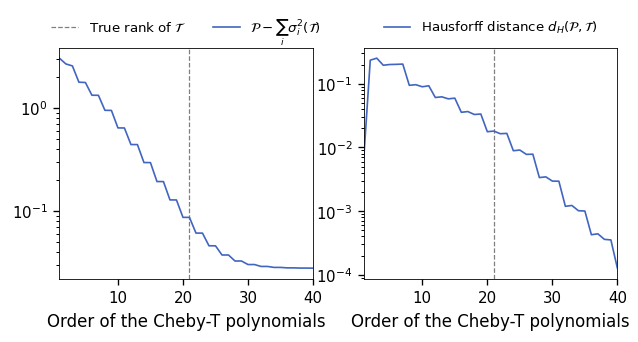

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
#SVD error
ax = axes[0]
ax.axvline(x=logistic.N + 1, linestyle='--', color='k', alpha=0.5, lw=0.75, label ='True rank of $\\mathcal{T}$')
poly_order = len(flattened['SVD-error'])
ax.plot(np.arange(1, poly_order + 1), flattened['SVD-error'], label = r"$\mathcal{P} - \sum_{i} \sigma_{i}^{2}(\mathcal{T})$")

ax.set_xlabel('Order of the Cheby-T polynomials')
ax.set_yscale('log')
ax.set_xmargin(0)
ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 0.95, 1, 0), ncol=2, fontsize=8)

ax = axes[1]
#Hausdorff distance
ax.axvline(x=logistic.N + 1, linestyle='--', color='k', alpha=0.5, lw=0.75)
ax.plot(np.arange(1, poly_order + 1), flattened['hausdorff-dist'], label = r"Hausforff distance $d_{H}(\mathcal{P}, \mathcal{T})$")
ax.set_xlabel('Order of the Cheby-T polynomials')
ax.set_yscale('log')
ax.set_xmargin(0)
ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=1, fontsize=8)

### Defining a standard MLP architecture

In [142]:
from collections import OrderedDict
from copy import deepcopy
class SimpleMLP(torch.nn.Module):
    def __init__(self, hidden_dim: int, layer_dims: list[int]):
        super().__init__()
        self.layer_dims = deepcopy(layer_dims)
        self.layer_dims.append(hidden_dim)
        self.layer_dims.insert(0, 1)
        #Create an MLP from the layer dimensions
        module_dict = OrderedDict()
        for i in range(len(self.layer_dims) - 2):
            module_dict[f"linear_{i}"] = torch.nn.Linear(self.layer_dims[i], self.layer_dims[i+1], bias=False)
            module_dict[f"activation_{i}"] = torch.nn.Tanh()
        module_dict[f"linear_{len(self.layer_dims) - 2}"] = torch.nn.Linear(self.layer_dims[-2], self.layer_dims[-1], bias=False)
        self.mlp = torch.nn.Sequential(module_dict)
    
    def forward(self, x):
        x = 2*x - 1 #Rescale logistic map data to [-1, 1]
        return self.mlp(x)

In [143]:
#Credits to https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/03-initialization-and-optimization.html#Initialization
import seaborn as sns
##############################################################
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape) > 1 else ""
        )
        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig
##############################################################
def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()
##############################################################
def visualize_activations(model, train_dl, device, color="C0", print_variance=False):
    model.eval()
    batch = next(iter(train_dl))
    feats = (batch[:, :1, ...]).to(device)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.mlp):
            feats = layer(feats)
            if isinstance(layer, torch.nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()
    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")
##############################################################
import math
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)

def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("linear_0"):  # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1 / math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, 5.0 / (3*math.sqrt(param.shape[1])))

## VAMPNets

In [144]:
dl_reports = {}

In [145]:
#Preparing the data
train_data = torch.from_numpy(dataset['train']).float()
val_data = torch.from_numpy(dataset['validation']).float()

train_ds = TrajToContextsDataset(train_data)
val_ds = TrajToContextsDataset(val_data)

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

In [146]:
%autoreload 2
from kooplearn.models.feature_maps import VAMPNet
lr_finder = LearningRateFinder(min_lr=1e-4, max_lr=1e-2, early_stop_threshold=None)
trainer_kwargs = {
    'accelerator': 'cpu',
    'devices': 1,
    'max_epochs': 200,  
    'log_every_n_steps': 3,
    'callbacks': [lr_finder],
}
trainer = lightning.Trainer(**trainer_kwargs)

lobe_kwargs = {
    'hidden_dim': configs.latent_dim,
    'layer_dims': configs.mlp_layer_dims
}

#Defining the model
feature_map = VAMPNet(
    SimpleMLP,
    torch.optim.Adam,
    {'lr': 1e-6},
    trainer,
    lobe_kwargs,
    lobe_timelagged=SimpleMLP,
    lobe_timelagged_kwargs=lobe_kwargs,
    center_covariances=False,
    seed=configs.rng_seed
)

#Init
kaiming_init(feature_map.lightning_module.lobe)
kaiming_init(feature_map.lightning_module.lobe_timelagged)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0


In [147]:
#visualize_activations(feature_map.lightning_module.lobe, train_dl, feature_map.lightning_module.device, print_variance=True)

In [148]:
feature_map.fit(train_dl)
dl_reports['VAMPNet'] = evaluate_representation(feature_map)

Fitting VAMPNet. Lookback window length set to 1


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0002754228703338166
Restoring states from the checkpoint path at /home/novelli/kooplearn/examples/logistic_map/.lr_find_d865554f-1320-40ac-a6c8-1d6ab554ee40.ckpt
Restored all states from the checkpoint at /home/novelli/kooplearn/examples/logistic_map/.lr_find_d865554f-1320-40ac-a6c8-1d6ab554ee40.ckpt

  | Name            | Type      | Params
----------------------------------------------
0 | lobe            | SimpleMLP | 5.2 K 
1 | lobe_timelagged | SimpleMLP | 5.2 K 
----------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.041     Total estimated model params size (MB)
Restored all states from the checkpoint at /home/novelli/kooplearn/examples/logistic_map/.lr_find_d865554f-1320-40ac-a6c8-1d6ab554ee40.ckpt


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Training VAMPNets is hard: no learning rate in the range $(10^{-8}, 10^{-2})$ give a good result, and the $\mathcal{P}$ gets stuck at a local minima $\mathcal{P} = 1$. We now turn on to DPNets, adding metric regularization first, and later studying the effect of loss relaxation.

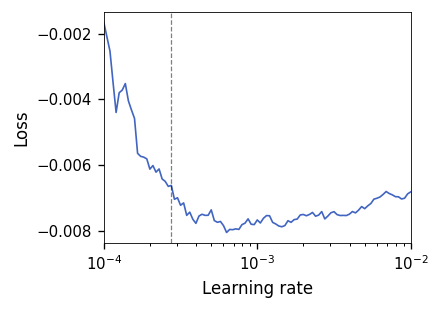

In [149]:
fig = lr_finder.optimal_lr.plot()
#Add the optimal learning rate to the plot
ax = fig.axes[0]
ax.axvline(x=lr_finder.optimal_lr.suggestion(), linestyle='--', color='k', alpha=0.5, lw=0.75, label ='Optimal learning rate')
ax.margins(x=0)

## DPNets

In [150]:
%autoreload 2
from kooplearn.models.feature_maps import DPNet
lr_finder = LearningRateFinder(min_lr=1e-4, max_lr=1e-2, early_stop_threshold=None)
trainer_kwargs = {
    'accelerator': 'cpu',
    'devices': 1,
    'max_epochs': 200,  
    'log_every_n_steps': 3,
    'callbacks': [lr_finder],
}
trainer = lightning.Trainer(**trainer_kwargs)

encoder_kwargs = {
    'hidden_dim': configs.latent_dim,
    'layer_dims': configs.mlp_layer_dims
}

#Defining the model
feature_map = DPNet(
    SimpleMLP,
    torch.optim.Adam,
    {'lr': 1e-6},
    trainer,
    use_relaxed_loss=False,
    metric_deformation_loss_coefficient=0.5,
    encoder_kwargs=encoder_kwargs,
    encoder_timelagged=SimpleMLP,
    encoder_timelagged_kwargs=encoder_kwargs,
    center_covariances=True,
    seed=configs.rng_seed
)

#Init
kaiming_init(feature_map.lightning_module.encoder)
kaiming_init(feature_map.lightning_module.encoder_timelagged)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
Global seed set to 0


In [151]:
feature_map.fit(train_dl)
dl_reports['DPNet'] = evaluate_representation(feature_map)

Fitting DPNet. Lookback window length set to 1


/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0005248074602497726
Restoring states from the checkpoint path at /home/novelli/kooplearn/examples/logistic_map/.lr_find_b4a3dedc-4b16-4bd4-a626-042f9733fda7.ckpt
Restored all states from the checkpoint at /home/novelli/kooplearn/examples/logistic_map/.lr_find_b4a3dedc-4b16-4bd4-a626-042f9733fda7.ckpt

  | Name               | Type      | Params
-------------------------------------------------
0 | encoder            | SimpleMLP | 5.2 K 
1 | encoder_timelagged | SimpleMLP | 5.2 K 
-------------------------------------------------
10.4 K    Trainable params
0         Non-trainable params
10.4 K    Total params
0.041     Total estimated model params size (MB)
Restored all states from the checkpoint at /home/novelli/kooplearn/examples/logistic_map/.lr_find_b4a3dedc-4b16-4bd4-a626-042f9733fda7.ckpt


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


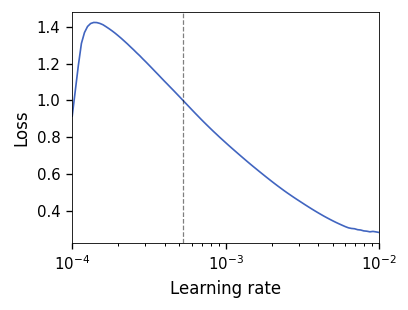

In [152]:
fig = lr_finder.optimal_lr.plot()
#Add the optimal learning rate to the plot
ax = fig.axes[0]
ax.axvline(x=lr_finder.optimal_lr.suggestion(), linestyle='--', color='k', alpha=0.5, lw=0.75, label ='Optimal learning rate')
ax.margins(x=0)

In [153]:
model_name = f"ChebyT-{3}"
dl_reports[model_name] = evaluate_representation(ChebyT(3))

In [154]:
tabulate_reports(dl_reports)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Representation ┃ Hausdorff dist ┃ SVD Error ┃ ||Id - cov||^2 ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│        VAMPNet │     0.006      │   4.035   │     0.636      │
│          DPNet │     0.008      │   4.035   │     0.497      │
│       ChebyT-3 │     0.253      │   2.555   │     0.263      │
└────────────────┴────────────────┴───────────┴────────────────┘

In [155]:
cov, cross_cov = population_covs(feature_map)

In [156]:
np.linalg.eigvals(np.linalg.solve(cov, cross_cov))

array([ 0.00818633, -0.00880887, -0.00025039])